# Boston House Prices Dataset

In this notebook we build linear models to predict the median house prices in the Boston Housing dataset.

In [1]:
import random
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, ElasticNet

from mlbook.utils.losses import mse 
from mlbook.utils.splitters import *
from mlbook.linear_regression.enet import *
from mlbook.linear_regression.common import *

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Setup Seaborn
sns.set(rc={"figure.figsize": (10, 8), "font.size": 11})
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.0, rc={"lines.linewidth": 2.5})

## Load and preprocess data

In [2]:
# Get data
boston=load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
X = boston['data']
y = boston['target']

# Convert to dataframe
feats = boston["feature_names"]
df_boston = pd.DataFrame(X, columns=feats) 
df_boston['MEDV'] = y

In [4]:
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


First, we split data into training (80%) and test (20%) sets.

In [5]:
# Train-test split
seed = 1984
X = df_boston[feats].values
idx_ts, idx_tr = train_test(len(X), seed=seed)
X_train, X_test = X[idx_tr], X[idx_ts]
y_train, y_test = y[idx_tr], y[idx_ts]

df_train = pd.DataFrame(X_train, columns=feats)
df_test = pd.DataFrame(X_test, columns=feats)

Next, we peform transform the features so that they are scaled in a way to have similar ranges. This helps the regularization term treat all features at the same footing. 

Instead of using the mean to center and standard deviation to scale, we will use the median and the interquartile range (IQR). This is also known as the robust scaler, since the IQR and median are less prone to outliers than mean and standard deviation.

We determine the median and IQR from the training set and use those values to transform the test set values.

In [6]:
# -- Scale features (except for CHAS, which is binary)
feats_to_scale = [f for f in feats if f != 'CHAS']
X_ = df_train[feats_to_scale].values

# Scale data by quantiles (robust scaling by IQR)
q25, q50, q75 = np.percentile(X_, q=[25,50, 75], axis=0)
scale_ = q75 - q25
center_ = q50
X_rscl = (X_ - center_) / scale_

# Train 
df_train_new = pd.DataFrame(X_rscl, columns=feats_to_scale)
df_train_new['CHAS'] = df_train['CHAS'].values

# Test
X_ = df_test[feats_to_scale].values
X_ = (X_ - center_) / scale_

df_test_new = pd.DataFrame(X_, columns=feats_to_scale)
df_test_new['CHAS'] = df_test['CHAS'].values

## Effect of $L_1$ and $L_2$ penatlies

Let's try various values of $\lambda$ and $\alpha$. This will help us compare the effect of regularization with varying levels of $L_1$ and $L_2$ contributions. For $\alpha=0$, we have pure $L_2$ penalty (i.e. ridge regression) and for $\alpha=1$, we have pure $L_1$ penalty (i.e. LASSO). 

Below, we fit elasticnet for a range of $\lambda$ values for a given $\alpha$. Then we compare the resulting coefficients resulting from the fits.

In [7]:
alpha = 0.0
lams = np.logspace(-1,1,21)
X_train = df_train_new[feats].values
X_test = df_test_new[feats].values

# Loop over different alphas
betaHatArray0 = np.zeros((len(lams), X_train.shape[1]))
for il, lam in enumerate(lams):
    beta0_i, beta_i = init_coef(X_train, y_train) # From univariate fit
    results = fit(X_train, y_train, lam=lam, al=alpha, tol=1e-4, maxIter=500,
                                initBeta0 = beta0_i, initBeta = beta_i)

    yHat = predict(X_train, results['beta0Hat'], results['betaHat'])
    betaHatArray0[il] = results['betaHat']


In [8]:
alpha = 0.5
lams = np.logspace(-1,1,21)
X_train = df_train_new[feats].values
X_test = df_test_new[feats].values

# Loop over different alphas
betaHatArray1 = np.zeros((len(lams), X_train.shape[1]))
for il, lam in enumerate(lams):
    beta0_i, beta_i = init_coef(X_train, y_train) # From univariate fit
    results = fit(X_train, y_train, lam=lam, al=alpha, tol=1e-4, maxIter=500,
                                initBeta0 = beta0_i, initBeta = beta_i)

    yHat = predict(X_train, results['beta0Hat'], results['betaHat'])
    betaHatArray1[il] = results['betaHat']


In [9]:
alpha = 1.0
lams = np.logspace(-1,1,21)
X_train = df_train_new[feats].values
X_test = df_test_new[feats].values

# Loop over different alphas
betaHatArray2 = np.zeros((len(lams), X_train.shape[1]))
for il, lam in enumerate(lams):
    beta0_i, beta_i = init_coef(X_train, y_train) # From univariate fit
    results = fit(X_train, y_train, lam=lam, al=alpha, tol=1e-4, maxIter=500,
                                initBeta0 = beta0_i, initBeta = beta_i)

    yHat = predict(X_train, results['beta0Hat'], results['betaHat'])
    betaHatArray2[il] = results['betaHat']


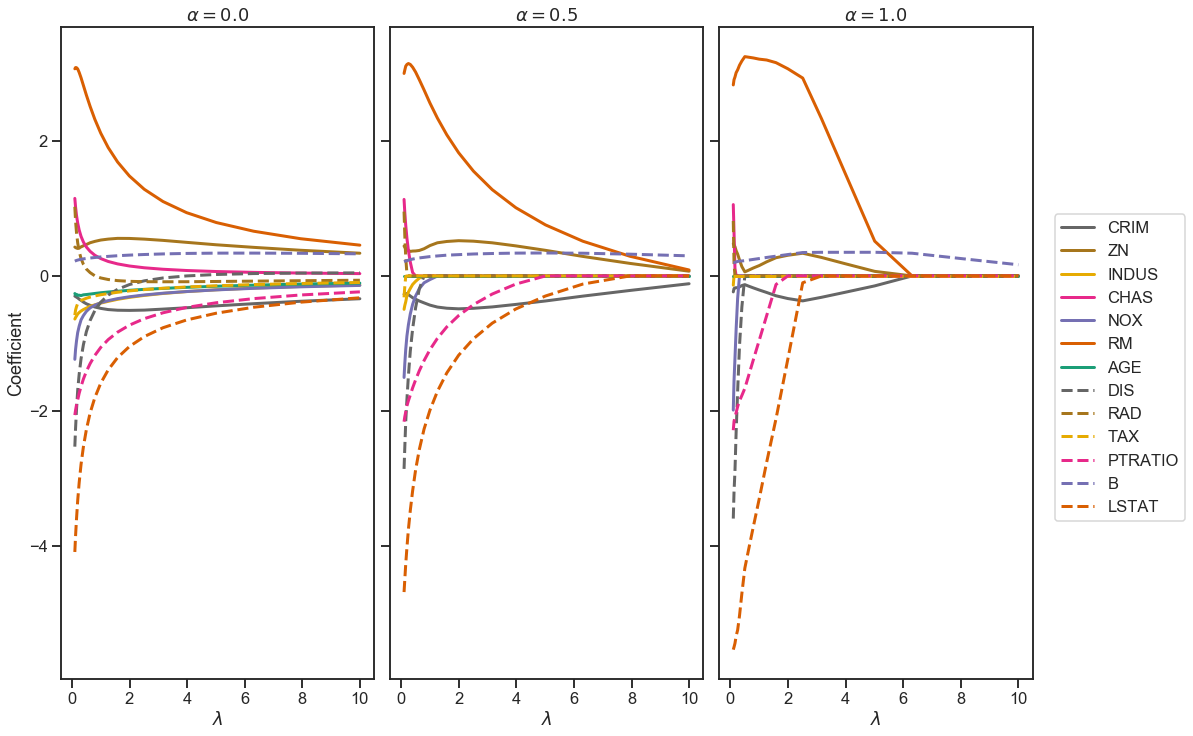

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize=(18,12))

ncol = 7
colors = plt.cm.Dark2_r(np.linspace(0,1,ncol))
styles = ['-','--']
col_style = list(zip(colors,styles))

for idx_f, feat in enumerate(feats):
    col_idx = idx_f % 7
    sty_idx = idx_f // 7 
    
    ax1.plot(lams, betaHatArray0[:,idx_f], label=feat, lw = 3.0, color = colors[col_idx], linestyle = styles[sty_idx])
    ax1.set_title(r'$\alpha = 0.0$')
    ax1.set_xlabel(r'$\lambda$')
    ax1.set_ylabel('Coefficient')
    
    ax2.plot(lams, betaHatArray1[:,idx_f], label=feat, lw = 3.0, color = colors[col_idx], linestyle = styles[sty_idx])
    ax2.set_title(r'$\alpha = 0.5$')
    ax2.set_xlabel(r'$\lambda$')
    
    ax3.plot(lams, betaHatArray2[:,idx_f], label=feat, lw = 3.0, color = colors[col_idx], linestyle = styles[sty_idx])
    ax3.set_title(r'$\alpha = 1.0$')
    ax3.set_xlabel(r'$\lambda$')    
    
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

plt.subplots_adjust(wspace=0.05, right=0.875)
plt.show()
#plt.savefig("boston_lambda.pdf")

## Finding best hyper-parameters

As an example we find the best `al` and `lam` by k-folds cross-validation.

In [11]:
# Construct a grid of values
alphas = np.linspace(0,1,5)
lams = np.logspace(-3,0,21)
grid = [(al,lam) for al in alphas for lam in lams]

# Use 10 folds cross-validation
kfolds = 10
X_train = df_train_new[feats].values
X_test = df_test_new[feats].values

cv_results = np.zeros((kfolds,len(grid)))
for il, (al,lam) in enumerate(grid):
    
    # For each lam, perform 5 folds CV
    for ik, (idx_vld, idx_tr) in enumerate(k_fold_gen(len(X_train), k = kfolds, seed=seed)):
        xx_tr, xx_vld = X_train[idx_tr], X_train[idx_vld]
        y_tr, y_vld = y_train[idx_tr], y_train[idx_vld]
    
        # Fit on xx_tr, predict on xx_vld
        beta0_i, beta_i = init_coef(xx_tr, y_tr) # From univariate fit
        results = fit(xx_tr, y_tr, lam=lam, al=al, tol=1e-4, maxIter=500,
                                    initBeta0 = beta0_i, initBeta = beta_i)

        yHat = predict(xx_vld, results['beta0Hat'], results['betaHat'])
        cv_results[ik,il] = mse(y_vld, yHat)
    

In [12]:
# Mean values and quantiles over folds
mus = cv_results.mean(axis=0)
q25, q75 = np.percentile(cv_results,[25,75],axis=0)
low, high = np.min(cv_results, axis=0), np.max(cv_results, axis=0)

Best `al` and `lam` is chosen to be the one which leads to minimum mean value of mean squared error (MSE) across k-folds.

In [13]:
best_idx = np.argmin(mus)
print("Best al = {:.4f} :: best lam = {:.4f}".format(grid[best_idx][0],grid[best_idx][1]))

Best al = 1.0000 :: best lam = 0.0158


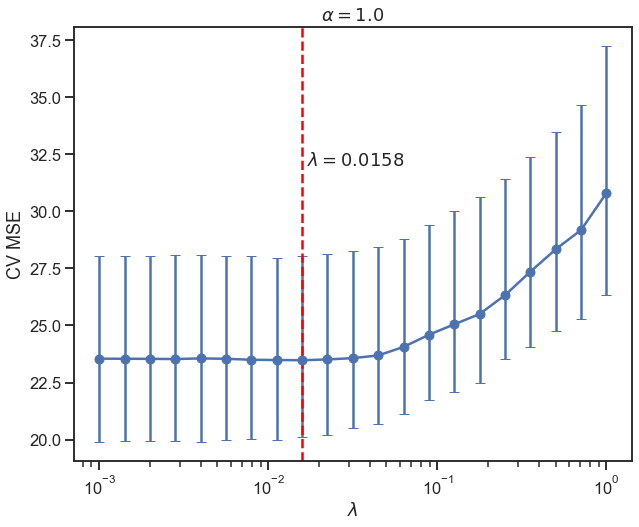

In [15]:
# Lams for best alpha
best_al_idx = [i for i,(al, lam) in enumerate(grid) if al == 1.0]

# Plot CV error for best alpha with varying lambda
mus_ = mus[best_al_idx]
q25_, q75_ = q25[best_al_idx], q75[best_al_idx]

plt.errorbar(lams, mus_, yerr = [mus_ - q25_, q75_ - mus_], fmt='-o',capsize=5)
plt.axvline(grid[best_idx][1], color='red', linestyle='--')
plt.xscale('log')
plt.text(grid[best_idx][1]+0.001, 32, r'$\lambda = {:.4f}$'.format(grid[best_idx][1]))
plt.xlabel(r'$\lambda$')
plt.ylabel('CV MSE')
plt.title(r'$\alpha = 1.0$')
#plt.show()
plt.savefig('boston_cv_lambda.pdf')

In this figure, we also plot an error bar for each MSE determined from the 25th and 75th percentile of the values from the 10 folds.

After the best values for `al` and `lam` are determined, we perform one last fit on the full training set and predict the test set. 

In [16]:
# Final fit
beta0_i, beta_i = init_coef(X_train, y_train) # From univariate fit
results = fit(X_train, y_train, lam=grid[best_idx][1], al=grid[best_idx][0], tol=1e-4, maxIter=500,
                                    initBeta0 = beta0_i, initBeta = beta_i)

yHat_ts = predict(X_test, results['beta0Hat'], results['betaHat'])
mse_ts = mse(y_test, yHat_ts)

CV should also provide an estimate of the generalization (test) error:

In [17]:
print("Test MSE = {:.6f}".format(mse_ts))
print("CV estimate = {:.6f}".format(mus[best_idx]))

Test MSE = 23.469739
CV estimate = 23.477279


In [18]:
pd.Series(dict(zip(feats, results['betaHat']))).sort_values(ascending=False)

RAD        5.648767
RM         2.494843
CHAS       2.158953
ZN         0.639794
B          0.184401
AGE        0.000000
INDUS     -0.312239
CRIM      -0.374644
PTRATIO   -2.538630
NOX       -2.832516
TAX       -4.079297
DIS       -4.858893
LSTAT     -5.665811
dtype: float64

## Comparison with sklearn models

In sklearn implementation, $\lambda$ is `alpha`, and $\alpha$ is `l1_ratio` in `ElasticNet` object.

In [18]:
# -- sklearn
X_train = df_train_new[feats].values
X_test = df_test_new[feats].values
elnet = ElasticNet(alpha=0.01, l1_ratio=0.5)
elnet.fit(X_train, y_train)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [19]:
y_pred = elnet.predict(X_train)
mse(y_train, y_pred)

21.712891874155957

In [20]:
# -- Custom version
X_train = df_train_new[feats].values
X_test = df_test_new[feats].values

# ElasticNet
beta0_i, beta_i = init_coef(X_train, y_train) # From univariate fit
results = fit(X_train, y_train, lam=0.01, al=0.5, tol=1e-4, maxIter=500,
                            initBeta0 = beta0_i, initBeta = beta_i)

yHat = predict(X_train, results['beta0Hat'], results['betaHat'])
mse(y_train, yHat) 

21.698681587335717